# Tutorial on applying NDreamer to single cell experimental perturbation analysis

In this notebook, I will provide a step-by-step illustration on how to run NDreamer for single cell experimental perturbation analysis. We use the PBMC dataset as used in the manuscript, which comes from https://pubmed.ncbi.nlm.nih.gov/29227470/ and can be downloaded from https://drive.google.com/uc?id=1r87vhoLLq6PXAYdmyyd89zG90eJOFYLk. This tutorial may take about 3 minutes to run (tested on my personal computer with NVIDIA RTX 4090 LAPTOP).

First, import necessary packages

In [1]:
import scanpy as sc
import numpy as np
from ndreamer import NDreamer

Then, load the data using `scanpy`, suppose you downloaded it to './data/PBMC.h5ad'.

In [2]:
adata = sc.read_h5ad('./data/PBMC.h5ad')
print(adata)
print('condition',np.unique(adata.obs['condition']))
#print('batch',np.unique(adata.obs['batch']))
print('cell_type',np.unique(adata.obs['cell_type']))
print(adata.X[:10,:10])

AnnData object with n_obs × n_vars = 16893 × 6998
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'distances', 'connectivities'
condition ['control' 'stimulated']
cell_type ['B' 'CD14+Mono' 'CD4T' 'CD8T' 'Dendritic' 'FCGR3A+Mono' 'NK']
  (0, 6)	3.2066462
  (0, 7)	0.9476892
  (1, 6)	3.3140597
  (2, 6)	2.3448765
  (3, 6)	2.2920933
  (4, 6)	2.4309647
  (5, 3)	0.29651934
  (5, 6)	3.0454638
  (6, 6)	2.039655
  (7, 6)	3.9856381
  (8, 5)	0.5871326
  (8, 6)	4.531143
  (9, 6)	2.4054837


C:\Users\21202\.conda\envs\torch\lib\site-packages\anndata\compat\__init__.py:298: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
C:\Users\21202\.conda\envs\torch\lib\site-packages\anndata\compat\__init__.py:298: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


We can see that the dataset is stored in AnnData format, using Python package scanpy. 

There are two conditions in this dataset ('control' and 'stimulated'), as stored in the 'condition' obs in adata (adata.obs\['condition'\]).

Then, we define the NDreamer model. The model takes in a few parameters, we start with the most important inputs then move on to the default hyperparameters.

## Necessary inputs

- **adata** (`AnnData`):
  Single-cell gene expression data in `AnnData` format, typically preprocessed and stored as an `h5ad` file.

- **condition_key** (`str`):
  The key in `adata.obs` that contains condition labels. Here, it is 'condition' since the cell's condition meta data is stored in adata.obs\['condition'\].

- **control_name** (`str`, default: `'control'`):
  The name of the control condition in `adata.obs[condition_key]`. We will then calculate the individual treatment effect for all other conditions compared to the `control_name` condition. Here, the control name is "control".

- **num_hvg** (`int`, default: `2000`):
  Number of highly variable genes to select for analysis. If the input adata have number of genes more than `num_hvg`, then NDreamer will automatically select `num_hvg` number of highly variable genes.

- **require_batch** (`bool`, default: `False`):
  Whether batch correction is required. Here, we do not need it.

- **batch_key** (`str` or `None`, default: `None`):
  The key in `adata.obs` that contains batch labels (if batch correction is needed).

- **save_pth** (`str`, default: `"./PBMC/"`):
  Directory path for saving model outputs.

- **save_preprocessed_adata_path** (`str`, here we set it to: `"./PBMC/preprocessed.h5ad"`):
  Path to save the preprocessed `adata` file. If `None`, then the preprocessed results will not be saved

---

## Unnecessary inputs (default hyperparameter settings)

Then, the default hyperparameter settings is shown below:

- **resolution_low** (`float`, default: `0.5`):
  The lower resolution for the triplet loss calculation.

- **resolution_high** (`float`, default: `7`):
  The higher resolution for the triplet loss calculation.

- **cluster_method** (`str`, default: `"Leiden"`):
  The clustering algorithm to use (`"Leiden"` or `'Louvain'`).

- **embedding_dim** (`int`, default: `512`):
  The dimensionality of the embedding dimension in the VQ-VAE part.

- **codebooks** (`List[int]`, default: `[1024 for i in range(32)]`):
  A list defining the number of embeddings in each codebook.

- **codebook_dim** (`int`, default: `8`):
  The dimensionality of each embedding in the codebook.

- **encoder_hidden** (`List[int]`, default: `[1024, 512]`):
  A list specifying the hidden layer sizes for the encoder multi-layer perceptron.

- **decoder_hidden** (`List[int]`, default: `[512, 1024]`):
  A list specifying the hidden layer sizes for the decoder multi-layer perceptron.

- **z_dim** (`int`, default: `256`):
  The dimensionality of the latent effect modifier space representation.

- **cos_loss_scaler** (`float`, default: `20`):
  Scaling factor for the cosine similarity loss.

- **random_seed** (`int`, default: `123`):
  The random seed for reproducibility.

- **batch_size** (`int`, default: `1024`):
  The batch size for training.

- **epoches** (`int`, default: `100`):
  The number of training steps (**Attention that this is not epoch, this is in fact step**).

- **lr** (`float`, default: `1e-3`):
  The learning rate for the optimizer.

- **triplet_margin** (`float`, default: `5`):
  Margin value for the triplet loss function.

- **independent_loss_scaler** (`float`, default: `1000`):
  Scaling factor for the independent loss term.

- **developer_test_mode** (`bool`, default: `False`):
  Whether to enable developer test mode for debugging. Always set this to `False`.

- **library_size_normalize_adata** (`bool`, default: `False`):
  Whether to normalize `adata` based on library size.

- **KL_scaler** (`float`, default: `5e-3`):
  Scaling factor for the Kullback-Leibler divergence loss.

- **reconstruct_scaler** (`float`, default: `1`):
  Scaling factor for the reconstruction loss.

- **triplet_scaler** (`float`, default: `5`):
  Scaling factor for the triplet loss.

- **num_triplets_per_label** (`int`, default: `15`):
  Number of triplets to generate per label for triplet loss.

- **tau** (`float`, default: `0.01`):
  Temperature parameter for the gumbel softmax.

- **commitment_loss_scaler** (`float`, default: `1`):
  Scaling factor for the commitment loss.

- **cluster_correlation_scaler** (`float`, default: `50`):
  Scaling factor for cluster correlation loss.

- **reset_threshold** (`float`, default: `1/1024`):
  Threshold for resetting the unused embeddings in the codebooks during training.

- **reset_interval** (`int`, default: `30`):
  Number of steps after which reset operations are performed.

- **local_neighbor_across_cluster_scaler** (`float`, default: `20`):
  Scaling factor for local neighbor relationships across clusters.

- **try_identify_cb_specific_subtypes** (`bool`, default: `False`):
  Whether to attempt identification of condition-specific or batch-specific subtypes. Always set this to `False` unless you are pretty sure there are condition-specific or batch-specific cells.

- **local_neighborhood_loss_scaler** (`float`, default: `1`):
  Scaling factor for local neighborhood loss.

- **local_neighbor_sigma** (`float`, default: `1`):
  sigma for the gaussian kernel for local neighborhood computation.

- **try_identify_perturb_escaped_cell** (`bool`, default: `False`):
  Whether to identify perturbation-escaped cells. Always set this to `False` unless you are pretty sure there are cells that escape the perturbation for cells that are labeled as perturbed.

- **n_neighbors** (`int`, default: `20`):
  Number of nearest neighbors to consider in the local neighborhood loss computation.

In [3]:
# define the model
model = NDreamer(adata, condition_key="condition", contorl_name='control', num_hvg=2000, require_batch=False,
                        batch_key=None,
                        resolution_low=0.5, resolution_high=7, cluster_method="Leiden", embedding_dim=512,
                            codebooks=[1024 for i in range(32)],
                            codebook_dim=8, encoder_hidden=[1024, 512], decoder_hidden=[512, 1024], z_dim=256,
                            cos_loss_scaler=20, random_seed=123, batch_size=1024, epoches=100, lr=1e-3,
                            triplet_margin=5,independent_loss_scaler=1000, save_pth="./PBMC/",
                            developer_test_mode=False,
                            library_size_normalize_adata=False,
                            save_preprocessed_adata_path="./PBMC/preprocessed.h5ad",
                            KL_scaler=5e-3, reconstruct_scaler=1, triplet_scaler=5, num_triplets_per_label=15,
                            tau=0.01, commitment_loss_scaler=1, cluster_correlation_scaler=50,reset_threshold=1/1024,
                            reset_interval=30,try_identify_cb_specific_subtypes=False,
                            local_neighborhood_loss_scaler=1,local_neighbor_sigma=1,
                            try_identify_perturb_escaped_cell=False,n_neighbors=20,
                            local_neighbor_across_cluster_scaler=20)

# train the model
model.train_model()

# get the effect modifier space
model.get_modifier_space()

# denoise batch effect (if present)
model.decompose_true_expression_batch_effect_all(nearest_neighbor=1,bandwidth=1)

# Estimate ITE for conditions other than the control condition
model.Estmiate_ITE_all(nearest_neighbor=1,bandwidth=1)

Using device: cuda
1
Start data preprocessing
Original adata.obs[condition] back up to adata.obs['condition_backup']
Condition mapping to adata.obs['condition']: {'control': 0, 'stimulated': 1}
Condition mapping to adata.obs['batch']: {'batch': {0: 0}}
Unique batch mapping: {0: 0}
Calculating the clusters
Unique groups: ['0_0' '0_1']


D:\project\ndreamer\ndreamer\single_cell_utils.py:100: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_adata = clustered_adatas[0].concatenate(*clustered_adatas[1:], batch_key="batch_condition",


Finished clustering
Data preprocessing done
Remaining number of cells: 16893
Too few epoches (steps, if rigorously speaking). Changing epoch to 148 to adjust for number of cells
Require batch: False
Batch name to number mapping (may be used for search for saved adata):
 {'batch': {0: 0}}
Condition name to number mapping (may be used for search for saved adata):
 {'control': 0, 'stimulated': 1}
Preprocessing time: 16.55447 seconds


Overall Progress:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch: 1/148 | All Loss: 113.7868 | Neighborhood Loss: 16.0815 | Triplet Loss: 55.7395 | Reconstruction Loss: 18.2316 | Independent Loss: 31.2126 | KL Loss: 0.3755 | Commitment Loss: 0.5951 | Dependent Loss: -8.4490
Epoch: 2/148 | All Loss: 95.3171 | Neighborhood Loss: 14.3023 | Triplet Loss: 30.4468 | Reconstruction Loss: 13.5626 | Independent Loss: 45.2800 | KL Loss: 0.3540 | Commitment Loss: 0.5930 | Dependent Loss: -9.2217
Epoch: 3/148 | All Loss: 88.6109 | Neighborhood Loss: 14.7391 | Triplet Loss: 15.6964 | Reconstruction Loss: 10.5485 | Independent Loss: 56.3419 | KL Loss: 0.3793 | Commitment Loss: 0.5921 | Dependent Loss: -9.6865
Epoch: 4/148 | All Loss: 91.9501 | Neighborhood Loss: 15.0182 | Triplet Loss: 17.6811 | Reconstruction Loss: 8.7244 | Independent Loss: 59.5277 | KL Loss: 0.4065 | Commitment Loss: 0.5896 | Dependent Loss: -9.9975
Epoch: 5/148 | All Loss: 87.3551 | Neighborhood Loss: 15.0655 | Triplet Loss: 10.7219 | Reconstruction Loss: 7.7611 | Independent Loss: 63.1

## Illustration of the results

After the calculation, all results would be stored in `save_pth`, including:

1. `adata.h5ad`
    - `AnnData` object containing effect modifier embeddings:
        - `model.DL_model.adata.obsm['X_effect_modifier_space']`: Raw embeddings.
        - `model.DL_model.adata.obsm['X_effect_modifier_space_PCA']`: PCA-transformed embeddings.
    - Can be retrieved using: `model.DL_model.adata.copy()`.
    - There is also `adata.obs["original_order"]` that store the original order of each cell in the original input adata

2. `batch2num_mapping.pth`
    - Mapping of batch identifiers to numerical indices for batch encoding.

3. `ndreamer.pth`
    - Trained **NDreamer** model parameters.

4. `b-0--c-1__ITE.h5ad`
    - `AnnData` object storing **Individual Treatment Effects (ITE)** for condition `c=1` and batch `b=0`, the number here are number encoding for the condition and batch, if we do not consider batch effect, all data belongs to the `0` batch. The mapping between condition/ and the number is available at `condition2num_mapping.pth`

5. `condition2num_mapping.pth`
    - Mapping of condition labels to numerical indices.

6. `preprocessed.h5ad`
    - Preprocessed `AnnData` object used as input for model training.

In [4]:
adata1=model.DL_model.adata.copy()

## Then, we plot the effect modifier space

C:\Users\21202\.conda\envs\torch\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\21202\.conda\envs\torch\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


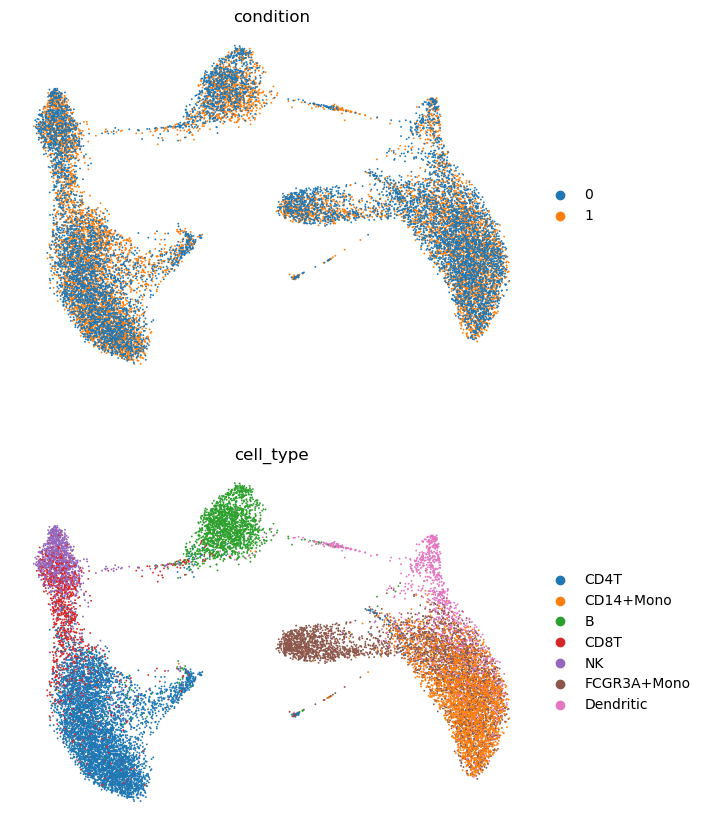

C:\Users\21202\.conda\envs\torch\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\21202\.conda\envs\torch\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


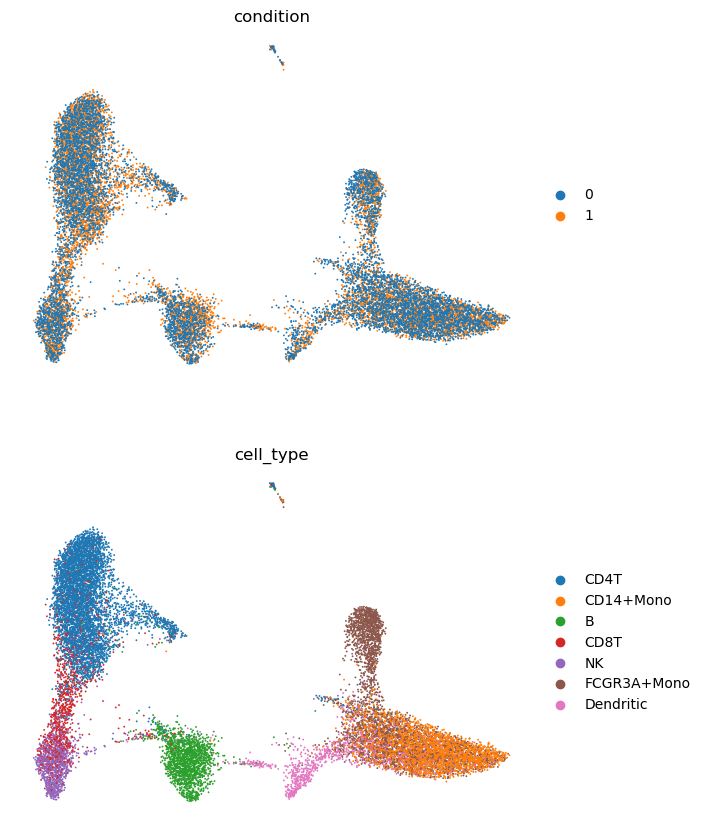

In [5]:
adata1=sc.read_h5ad("./PBMC/adata.h5ad")
sc.pp.neighbors(adata1, use_rep='X_effect_modifier_space_PCA', n_neighbors=25)
sc.tl.umap(adata1)
sc.pl.umap(adata1, color=['condition', 'cell_type'], frameon=False, ncols=1)

sc.pp.neighbors(adata1, use_rep='X_effect_modifier_space', n_neighbors=25)
sc.tl.umap(adata1)
sc.pl.umap(adata1, color=['condition', 'cell_type'], frameon=False, ncols=1)

## Plot the ITE

C:\Users\21202\.conda\envs\torch\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


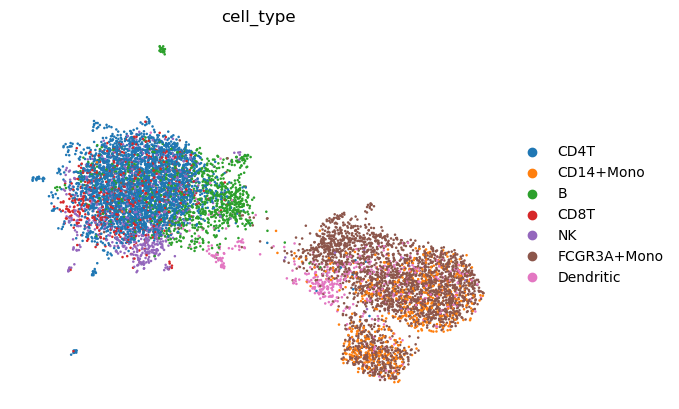

In [7]:
ITE=sc.read_h5ad("./PBMC/b-0--c-1__ITE.h5ad")
sc.pp.pca(ITE)
sc.pp.neighbors(ITE)
sc.tl.umap(ITE)
sc.pl.umap(ITE, color=['cell_type'], frameon=False, ncols=1)

---

## Evaluation of the effect modifier space

`metrics.py` is available in ./ndreamer, but please note that to run this code, you may need to install the kbet library in R environment and make sure that your rpy2 works properly.

In [6]:
import rpy2.robjects as robjects
import os
os.environ["R_HOME"]="/home/xx244/.conda/envs/benchmark/lib/R"
import anndata2ri
anndata2ri.activate()

from metrics import calculate_metrics

try:
    calculate_metrics(adata1, batch_key='condition', celltype_key='cell_type', all=True, n_neighbors=25, embed='X_effect_modifier_space_PCA')
except:
    calculate_metrics(adata1, batch_key='condition', celltype_key='cell_type', all=True, n_neighbors=25, embed='X_effect_modifier_space_PCA')

Unable to determine R library path: Command '('/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 127.
/tmp/ipykernel_3119450/4050021161.py:5: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/reproducible/metrics.py:29: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/xx24

R_HOME is already set to: /home/xx244/.conda/envs/benchmark/lib/R
LISI---
cLISI, bLISI, LISI_F1 0.9240201713503887 0.7381251428126299 0.8206773681315611
ASW---
asw_label 0.6258725672960281
asw_batch 0.9437358694002471
kBET---
0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4
Adding diffusion to step 4
Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7
Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7
Adding diffusion to step 8
Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 4
Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7
kbet_score 0.7614531557379514
graph_conn 0.971959528149517
NMI, ARI ---
NMI 0.7042585731321303
ARI 0.6519644968667847
positive and true positive rate---
                             ASW_label       ARI  